In [1]:
import pandas as pd
import numpy as np
from ladybug.epw import EPW
from lightning.pytorch import Trainer
from pathlib import Path

from ml.surrogate import Surrogate
from ml.predict import predict_ubem
from weather.weather import extract


Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
registry = "ml-for-building-energy-modeling/model-registry"
model = "Global UBEM Shoebox Surrogate with Combined TS Embedder"
tag = "v3"
resource = "model.ckpt"

surrogate = Surrogate.load_from_registry(registry, model, tag, resource)
surrogate.model.eval()

trainer = Trainer(
        accelerator="auto",
        devices="auto",
        strategy="auto",
        enable_progress_bar=True,
    )

c:\tools\Anaconda3\envs\ml-for-bem-final\lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'target_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['target_transform'])`.
c:\tools\Anaconda3\envs\ml-for-bem-final\lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'weather_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['weather_transform'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [3]:
sin_schedule = np.linspace(0,2*np.pi*365-1/24*2*np.pi,365*24)
sin_schedule = -np.cos(sin_schedule)/2 + 0.5
schedules = np.stack([sin_schedule]*3).reshape(1,3,8760)

In [4]:
epw = EPW("/teamspace/uploads/USA_NY_New.York-LaGuardia.AP.725030_TMYx.2004-2018.epw")
epw = EPW("C:/ProgramData/Solemma/Common/WeatherData/EPW/USA_CA_Los.Angeles.Intl.AP.722950_TMYx.2004-2018.epw")
epw = EPW("C:/ProgramData/Solemma/Common/WeatherData/EPW/USA_MA_Boston-Logan.Intl.AP.725090_TMYx.2004-2018.epw")
epw = EPW("C:/ProgramData/Solemma/Common/WeatherData/EPW/USA_NY_New.York-LaGuardia.AP.725030_TMYx.2004-2018.epw")
# epw = EPW("/teamspace/uploads/USA_CA_Los.Angeles.Intl.AP.722950_TMYx.2004-2018.epw")
# epw = EPW("/teamspace/uploads/USA_MA_Boston-Logan.Intl.AP.725090_TMYx.2004-2018.epw")
climate = extract(epw)

In [34]:
config = {
    "FacadeMass": 1,
    "RoofMass": 1,
    "FacadeRValue": 4.88,
    "RoofRValue": 4.88,
    "SlabRValue": 4.88,
    "WindowUValue": 2.0,
    "WindowShgc": 0.75,
    "PeopleDensity": 0.025,
    "EquipmentPowerDensity": 2,
    "LightingPowerDensity": 2,
    "HeatingSetpoint": 19,
    "CoolingSetpoint": 25,
    "cop_heating": 1,
    "cop_cooling": 1,
    "VentilationMode": 1,
    "VentilationPerArea": 0.0001,
    "VentilationPerPerson": 0.001,
    "EconomizerSettings": 1,
    "RecoverySettings": 2,
    "Infiltration": 0.00005,
    "wwr": 0.5,
    "template_idx": 0,
    "width": 3,
    "height": 4,
    "perim_depth": 3.6,
    "core_depth": 6.4,
    "building_id": 0,
    "weight": 1,
}
for i in range(12):
    config[f"shading_{i}"] = 0
features = pd.DataFrame(data=config, index=[0])
features = pd.concat([features]*12,axis=0)
features["roof_2_footprint"] = [0,0,1]*4
features["ground_2_footprint"] = [1,0,0]*4
# features["roof_2_footprint"] = [0.25]*12
# features["ground_2_footprint"] = [0.25]*12
features["orientation"] = [*[0]*3,*[np.pi/2]*3,*[np.pi]*3,*[3*np.pi/2]*3]

features.index = range(12)
for i in range(4):
    for j in range(3):
        features.loc[i*3+j,"name"] = f"{['bottom','middle','top'][j]}_{['south','east','north','west'][i]}"
shoebox_results, *_ = predict_ubem(trainer=trainer, surrogate=surrogate, features=features,schedules=schedules, climate=climate,apply_cops=False, batch_size=32,)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\tools\Anaconda3\envs\ml-for-bem-final\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 61.42it/s]


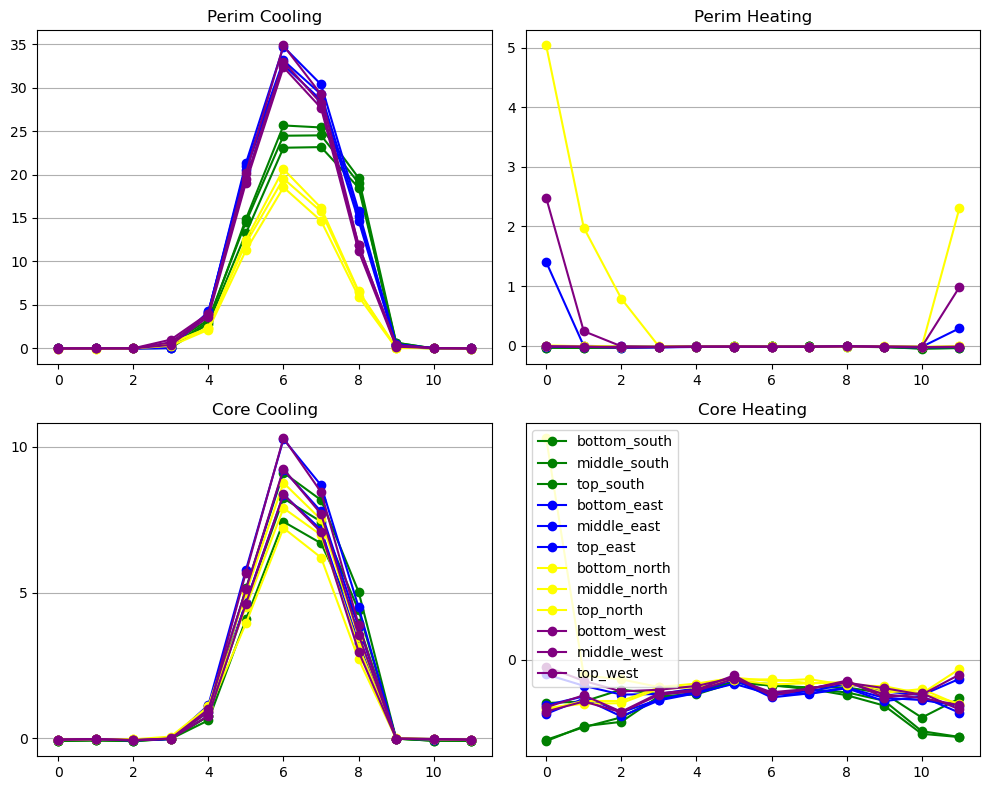

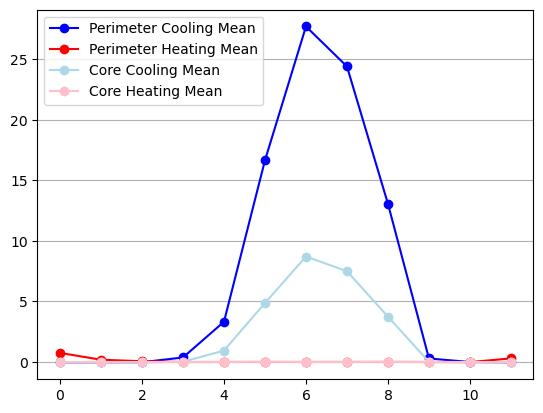

In [35]:
# shoebox_results = shoebox_results.set_index("box_name")
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

colors = {
    "bottom_south":"green",
    "middle_south": "green",
    "top_south": "green",
    "bottom_east":"blue",
    "middle_east": "blue",
    "top_east": "blue",
    "bottom_north":"yellow",
    "middle_north": "yellow",
    "top_north": "yellow",
    "bottom_west":"purple",
    "middle_west": "purple",
    "top_west": "purple",
}
fig,axs = plt.subplots(2,2,figsize=(10,8))
axs = [axs[0,0],axs[0,1],axs[1,0],axs[1,1]]

for i in range(12):
    axs[0].plot(shoebox_results["Perimeter"]["Cooling"].values[i],"-o",label=features.loc[i,"name"],c=colors[features.loc[i,"name"]])
    axs[1].plot(shoebox_results["Perimeter"]["Heating"].values[i],"-o",label=features.loc[i,"name"],c=colors[features.loc[i,"name"]])
    axs[2].plot(shoebox_results["Core"]["Cooling"].values[i],"-o",label=features.loc[i,"name"],c=colors[features.loc[i,"name"]])
    axs[3].plot(shoebox_results["Core"]["Heating"].values[i],"-o",label=features.loc[i,"name"],c=colors[features.loc[i,"name"]])


# axs[0].set_ylim([0,80])
# axs[1].set_ylim([0,5])
axs[0].yaxis.set_major_locator(MultipleLocator(5))
axs[1].yaxis.set_major_locator(MultipleLocator(1))
axs[2].yaxis.set_major_locator(MultipleLocator(5))
axs[3].yaxis.set_major_locator(MultipleLocator(1))

axs[0].grid(axis="y",which="major")
axs[1].grid(axis="y",which="major")
axs[2].grid(axis="y",which="major")
axs[3].grid(axis="y",which="major")

axs[0].set_title("Perim Cooling")
axs[1].set_title("Perim Heating")
axs[2].set_title("Core Cooling")
axs[3].set_title("Core Heating")
plt.legend()
fig.tight_layout()

fig = plt.figure()
plt.plot(shoebox_results["Perimeter"]["Cooling"].mean(axis=0).values,"-o",color="blue",label="Perimeter Cooling Mean")
plt.plot(shoebox_results["Perimeter"]["Heating"].mean(axis=0).values,"-o",color="red",label="Perimeter Heating Mean")
plt.plot(shoebox_results["Core"]["Cooling"].mean(axis=0).values,"-o",color="lightblue",label="Core Cooling Mean",)
plt.plot(shoebox_results["Core"]["Heating"].mean(axis=0).values,"-o",color="pink",label="Core Heating Mean",)
plt.gca().yaxis.set_major_locator(MultipleLocator(5))
plt.legend()
plt.grid(axis="y",which="major")